In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'omission'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
Please

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [3]:
rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('rewarded', 10, 10, plot=False)
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal ap

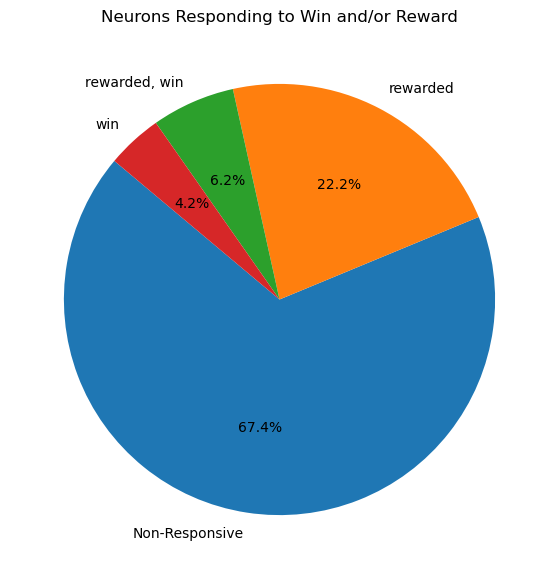

In [7]:
# Step 1: Concatenate the DataFrames
combined_df = pd.concat([rewarded_df, win_df])

# Function to extract just the event name
def extract_event_name(event):
    # Splits the string and extracts the part before 'vs'
    return event.split(' vs ')[0].replace('10s ', '')

# Initialize an empty dictionary to hold aggregated data
aggregated_data = {}

# Iterate over the rows of the combined DataFrame
for index, row in combined_df.iterrows():
    # Extract event name
    event_name = extract_event_name(row['Event'])
    # Construct a unique key for each combination of recording, subject, and unit id
    key = (row['Recording'], row['Subject'], row['original unit id'])
    
    # Initialize the entry if not exists
    if key not in aggregated_data:
        aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
    
    # Append the event name to the appropriate category based on 'event1 vs event2'
    if row['event1 vs event2'] == 'increases':
        aggregated_data[key]['sig_increase_events'].add(event_name)
    elif row['event1 vs event2'] == 'decreases':
        aggregated_data[key]['sig_decrease_events'].add(event_name)
    else:
        aggregated_data[key]['insig_events'].add(event_name)

# Convert the aggregated data into a DataFrame
rows = []
for (recording, subject, unit_id), categories in aggregated_data.items():
    row = {
        'Recording': recording,
        'Subject': subject,
        'original unit id': unit_id,
        'sig_increase_events': ', '.join(categories['sig_increase_events']),
        'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
        'insig_events': ', '.join(categories['insig_events']),
    }
    rows.append(row)

aggregated_df = pd.DataFrame(rows)

aggregated_df['sig_events'] = aggregated_df.apply(lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

# Function to normalize event strings
def normalize_event_string(event_string):
    event_list = event_string.split(', ')
    event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
    return ', '.join(event_list_sorted)  # Join the sorted list back into a string

# Apply the normalization function to the 'sig_events' column before counting
aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

# Count the unique combinations of significant events
sig_events_counts = aggregated_df['sig_events'].value_counts()

# Rename the empty strings to 'non-specific'
sig_events_counts = sig_events_counts.rename(index={'': 'Non-Responsive'})

# Group indexes containing ',' into 'multi-event specific'
# sig_events_counts['multi-event'] = sig_events_counts[[',' in index for index in sig_events_counts.index]].sum()
# sig_events_counts = sig_events_counts.drop(sig_events_counts[[',' in index for index in sig_events_counts.index]].index)

# Plot
plt.figure(figsize=(10, 7))
plt.pie(sig_events_counts, labels=sig_events_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Neurons Responding to Win and/or Reward')
plt.show()
# plt.savefig('Both_Rewarded_Wilcoxon_Pieplot_100msTimebin.png', bbox_inches='tight')

In [8]:
aggregated_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events
0,20230617_115521_standard_comp_to_omission_D1_s...,1-1,6,,,"rewarded, win",
1,20230617_115521_standard_comp_to_omission_D1_s...,1-1,60,,,"rewarded, win",
2,20230617_115521_standard_comp_to_omission_D1_s...,1-1,4,,,"rewarded, win",
3,20230617_115521_standard_comp_to_omission_D1_s...,1-1,59,win,,rewarded,win
4,20230617_115521_standard_comp_to_omission_D1_s...,1-1,39,win,,rewarded,win
...,...,...,...,...,...,...,...
139,20230621_111240_standard_comp_to_omission_D5_s...,1-4,89,rewarded,,win,rewarded
140,20230621_111240_standard_comp_to_omission_D5_s...,1-4,15,,,"rewarded, win",
141,20230621_111240_standard_comp_to_omission_D5_s...,1-4,74,rewarded,,win,rewarded
142,20230621_111240_standard_comp_to_omission_D5_s...,1-4,22,rewarded,,win,rewarded


In [10]:
def count_event_combinations(df):
    # Initialize dictionary to store counts of each combination
    combinations_counts = {
        'win_and_reward_insig': 0,
        'win_increase_reward_insig': 0,
        'win_decrease_reward_insig': 0,
        'reward_increase_win_insig': 0,
        'reward_decrease_win_insig': 0,
        'win_and_reward_increase': 0,
        'win_and_reward_decrease': 0,
        'win_increase_reward_decrease': 0,
        'win_decrease_reward_increase': 0,
    }

    # Iterate through the DataFrame
    for _, row in df.iterrows():
        # Split events into lists
        inc_events = row['sig_increase_events'].split(', ') if row['sig_increase_events'] else []
        dec_events = row['sig_decrease_events'].split(', ') if row['sig_decrease_events'] else []
        insig_events = row['insig_events'].split(', ') if row['insig_events'] else []

        # Define conditions for each combination
        win_insig = 'win' in insig_events
        reward_insig = 'reward' in insig_events
        win_increase = 'win' in inc_events
        win_decrease = 'win' in dec_events
        reward_increase = 'reward' in inc_events
        reward_decrease = 'reward' in dec_events

        # Increment counters based on conditions
        if win_insig and reward_insig:
            combinations_counts['win_and_reward_insig'] += 1
        if win_increase and reward_insig:
            combinations_counts['win_increase_reward_insig'] += 1
        if win_decrease and reward_insig:
            combinations_counts['win_decrease_reward_insig'] += 1
        if reward_increase and win_insig:
            combinations_counts['reward_increase_win_insig'] += 1
        if reward_decrease and win_insig:
            combinations_counts['reward_decrease_win_insig'] += 1
        if win_increase and reward_increase:
            combinations_counts['win_and_reward_increase'] += 1
        if win_decrease and reward_decrease:
            combinations_counts['win_and_reward_decrease'] += 1
        if win_increase and reward_decrease:
            combinations_counts['win_increase_reward_decrease'] += 1
        if win_decrease and reward_increase:
            combinations_counts['win_decrease_reward_increase'] += 1

    return combinations_counts

# Assuming 'df' is your DataFrame
combinations_counts = count_event_combinations(aggregated_df)
print(combinations_counts)

{'win_and_reward_insig': 0, 'win_increase_reward_insig': 0, 'win_decrease_reward_insig': 0, 'reward_increase_win_insig': 0, 'reward_decrease_win_insig': 0, 'win_and_reward_increase': 0, 'win_and_reward_decrease': 0, 'win_increase_reward_decrease': 0, 'win_decrease_reward_increase': 0}


In [11]:
def count_combinations(df):
    # Counters for each combination
    counters = {
        "win increase reward decrease": 0,
        "win decrease reward increase": 0,
        "win increase reward insig": 0,
        "win decrease reward insig": 0,
        "reward increase win insig": 0,
        "reward decrease win insig": 0,
        "win and reward insig": 0,
        "win and reward increase": 0,
        "win and reward decrease": 0,
    }

    # Iterate over DataFrame to populate counters
    for i, row in df.iterrows():
        win_inc = "win" in row["sig_increase_events"]
        win_dec = "win" in row["sig_decrease_events"]
        reward_inc = "rewarded" in row["sig_increase_events"]
        reward_dec = "rewarded" in row["sig_decrease_events"]
        win_insig = "win" in row["insig_events"]
        reward_insig = "rewarded" in row["insig_events"]
        
        if win_inc and reward_dec:
            counters["win increase reward decrease"] += 1
        elif win_dec and reward_inc:
            counters["win decrease reward increase"] += 1
        elif win_inc and reward_insig:
            counters["win increase reward insig"] += 1
        elif win_dec and reward_insig:
            counters["win decrease reward insig"] += 1
        elif reward_inc and win_insig:
            counters["reward increase win insig"] += 1
        elif reward_dec and win_insig:
            counters["reward decrease win insig"] += 1
        elif win_insig and reward_insig:
            counters["win and reward insig"] += 1
        elif win_inc and reward_inc:
            counters["win and reward increase"] += 1
        elif win_dec and reward_dec:
            counters["win and reward decrease"] += 1

    return counters

# Apply function to the aggregated_df
combination_counts = count_combinations(aggregated_df)
combination_counts

{'win increase reward decrease': 0,
 'win decrease reward increase': 1,
 'win increase reward insig': 6,
 'win decrease reward insig': 0,
 'reward increase win insig': 26,
 'reward decrease win insig': 6,
 'win and reward insig': 97,
 'win and reward increase': 3,
 'win and reward decrease': 5}

In [12]:
def count_combinations(df):
    # Counters for each combination
    counters = {
        "Win Excitatory & Reward Inhibitory": 0,
        "Win Inhibitory & Reward Excitatory": 0,
        "Win Excitatory": 0,
        "Win Inhibitory": 0,
        "Reward Excitatory": 0,
        "Reward Inhibitory": 0,
        "Non-Responsive": 0,
        "Win & Reward Excitatory": 0,
        "Win & Reward Inhibitory": 0,
    }

    # Iterate over DataFrame to populate counters
    for i, row in df.iterrows():
        win_inc = "win" in row["sig_increase_events"]
        win_dec = "win" in row["sig_decrease_events"]
        reward_inc = "rewarded" in row["sig_increase_events"]
        reward_dec = "rewarded" in row["sig_decrease_events"]
        win_insig = "win" in row["insig_events"]
        reward_insig = "rewarded" in row["insig_events"]
        both_insig = "rewarded" and "win" in row["insig_events"]
        
        if win_inc and reward_dec:
            counters["Win Excitatory & Reward Inhibitory"] += 1
        elif win_dec and reward_inc:
            counters["Win Inhibitory & Reward Excitatory"] += 1
        elif win_inc and reward_insig:
            counters["Win Excitatory"] += 1
        elif win_dec and reward_insig:
            counters["Win Inhibitory"] += 1
        elif reward_inc and win_insig:
            counters["Reward Excitatory"] += 1
        elif reward_dec and win_insig:
            counters["Reward Inhibitory"] += 1
        elif win_insig and reward_insig:
            counters["Non-Responsive"] += 1
        elif win_inc and reward_inc:
            counters["Win & Reward Excitatory"] += 1
        elif win_dec and reward_dec:
            counters["Win & Reward Inhibitory"] += 1

    return counters

# Apply function to the aggregated_df
combination_counts = count_combinations(aggregated_df)
combination_counts

{'Win Excitatory, Reward Inhibitory': 0,
 'Win Inhibitory, Reward Excitatory': 1,
 'Win Excitatory': 6,
 'Win Inhibitory': 0,
 'Reward Excitatory': 26,
 'Reward Inhibitory': 6,
 'Non-Responsive': 97,
 'Win & Reward Excitatory': 3,
 'Win & Reward Inhibitory': 5}

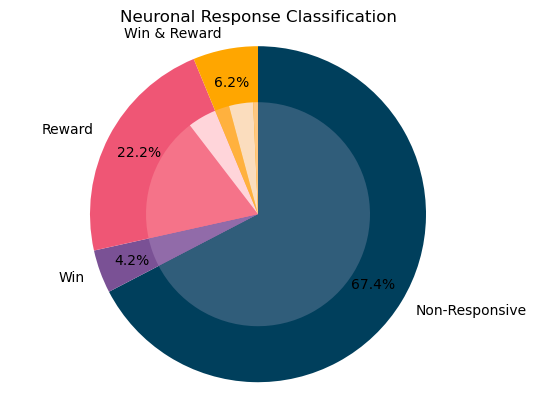

In [24]:
import matplotlib.pyplot as plt

# Outer Pie Categories and counts
outer_labels = ['Non-Responsive', 'Win', 'Reward', 'Win & Reward']
outer_sizes = [
    combination_counts['Non-Responsive'], 
    combination_counts['Win Excitatory'],
    combination_counts['Reward Excitatory'] + combination_counts['Reward Inhibitory'],
    combination_counts['Win & Reward Excitatory'] + combination_counts['Win & Reward Inhibitory'] + combination_counts['Win Inhibitory, Reward Excitatory'] + combination_counts['Win Excitatory, Reward Inhibitory']
]
outer_colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
outer_explode = (0.1, 0.2, 0.2, 0.2)  # only "explode" the second slice

# Inner Pie Categories and counts
inner_labels = [
    '', '',  # Placeholder for Non-Responsive and Win (only has excitatory)
    'Reward Excitatory', 'Reward Inhibitory',  # For Reward
    'Win & Reward Excitatory', 'Win & Reward Inhibitory', 'Different'  # For Win & Reward
]
inner_sizes = [
    97, 6,  # Placeholder sizes for Non-Responsive and Win (already counted in outer pie)
    combination_counts['Reward Excitatory'], combination_counts['Reward Inhibitory'],  # For Reward
    combination_counts['Win & Reward Excitatory'], combination_counts['Win & Reward Inhibitory'], combination_counts['Win Inhibitory, Reward Excitatory'] + combination_counts['Win Excitatory, Reward Inhibitory']  # For Win & Reward
]
inner_colors = ['#305d7a', '#916ba9', '#f57389', '#ffd5da', '#ffb13e', '#fbddbe', '#ffc780']

# Plot
fig, ax = plt.subplots()
ax.pie(outer_sizes, labels=outer_labels, pctdistance=0.8, autopct='%1.1f%%', startangle=90, colors=outer_colors, radius=1.2, counterclock=False)
ax.pie(inner_sizes, startangle=90, colors=inner_colors, radius=0.8, counterclock=False)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.title('Neuronal Response Classification')
plt.show()

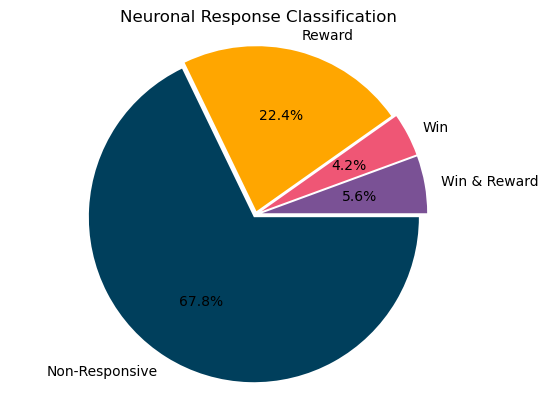

In [42]:
import matplotlib.pyplot as plt

# Data for pie chart
labels = ['Non-Responsive', 'Reward', 'Win', 'Win & Reward']
sizes = [97, 32, 6, 8]  # Sum of Excitatory and Inhibitory for Reward and Win & Reward
colors = ['#003f5c', '#ffa600', '#ef5675', '#7a5195']
explode = (0.02, 0.02, 0.04, 0.04)  # Only "Reward" and "Win & Reward" explode

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=0, colors=colors, explode=explode, counterclock=False)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Neuronal Response Classification')
plt.show()

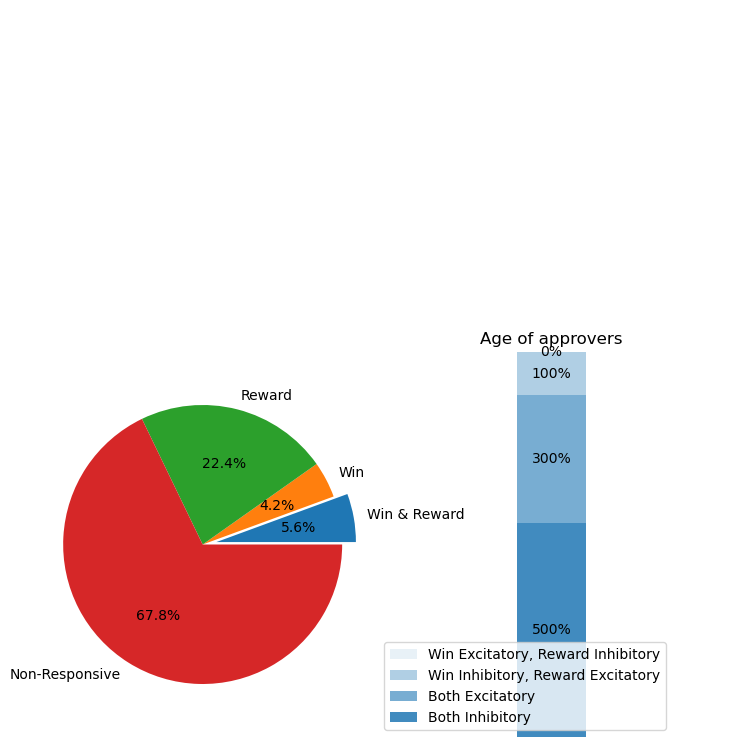

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [8, 6, 32, 97]
labels = ['Win & Reward', 'Win', 'Reward', 'Non-Responsive']
explode = [0.1, 0, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [5, 3, 1, 0]
age_labels = ['Both Inhibitory', 'Both Excitatory', 'Win Inhibitory, Reward Excitatory', 'Win Excitatory, Reward Inhibitory']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

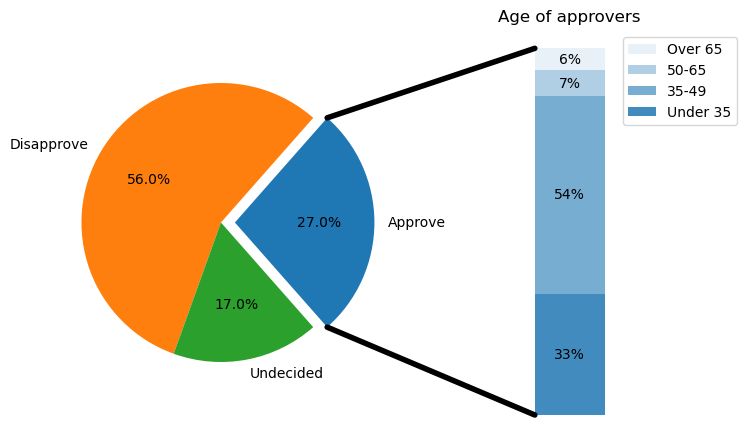

In [44]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.33, .54, .07, .06]
age_labels = ['Under 35', '35-49', '50-65', 'Over 65']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

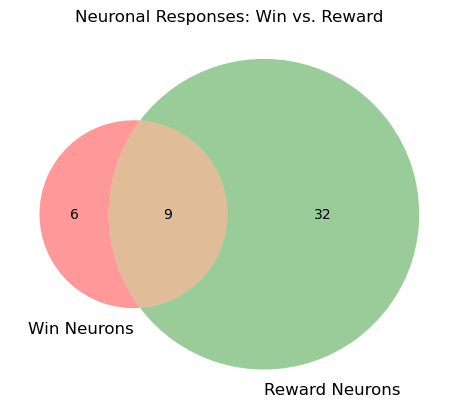

In [12]:
import matplotlib_venn
import matplotlib.pyplot as plt

{'Win Excitatory, Reward Inhibitory': 0,
 'Win Inhibitory, Reward Excitatory': 1,
 'Win Excitatory': 6,
 'Win Inhibitory': 0,
 'Reward Excitatory': 26,
 'Reward Inhibitory': 6,
 'Non-Responsive': 97,
 'Win & Reward Excitatory': 3,
 'Win & Reward Inhibitory': 5}

win_neurons = 6
reward_neurons = 32
win_reward_overlap = 9

venn2(subsets=(win_neurons, reward_neurons, win_reward_overlap),
      set_labels=('Win Neurons', 'Reward Neurons'))

plt.title('Neuronal Responses: Win vs. Reward')
# plt.show()
plt.savefig('Win_Reward_Venn.png', bbox_inches='tight')

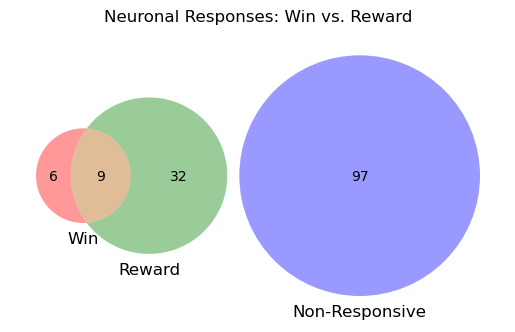

In [11]:
import matplotlib_venn
import matplotlib.pyplot as plt

{'Win Excitatory, Reward Inhibitory': 0,
 'Win Inhibitory, Reward Excitatory': 1,
 'Win Excitatory': 6,
 'Win Inhibitory': 0,
 'Reward Excitatory': 26,
 'Reward Inhibitory': 6,
 'Non-Responsive': 97,
 'Win & Reward Excitatory': 3,
 'Win & Reward Inhibitory': 5}

win_neurons = 6
reward_neurons = 32
win_reward_overlap = 9
non_responsive = 97

matplotlib_venn.venn3(subsets = (6, 32, 9, 97, 0, 0, 0), set_labels = ('Win', 'Reward', 'Non-Responsive'))

plt.title('Neuronal Responses: Win vs. Reward')
# plt.show()
plt.savefig('Win_Reward_NR_Venn.png', bbox_inches='tight')

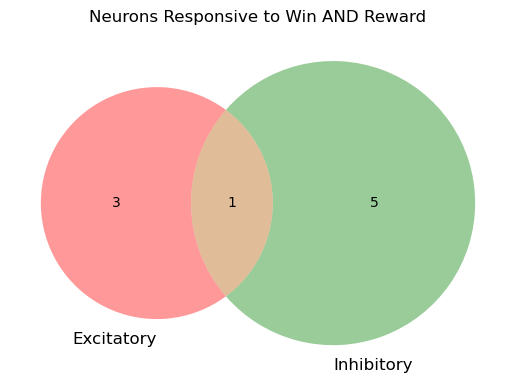

In [15]:
import matplotlib_venn
import matplotlib.pyplot as plt

{'Win Excitatory, Reward Inhibitory': 0,
 'Win Inhibitory, Reward Excitatory': 1,
 'Win Excitatory': 6,
 'Win Inhibitory': 0,
 'Reward Excitatory': 26,
 'Reward Inhibitory': 6,
 'Non-Responsive': 97,
 'Win & Reward Excitatory': 3,
 'Win & Reward Inhibitory': 5}

Win_Reward_Excitatory = 3
Win_Reward_Inhibitory = 5
Win_Reward_Diff = 1

venn2(subsets=(Win_Reward_Excitatory, Win_Reward_Inhibitory, Win_Reward_Diff),
      set_labels=('Excitatory', 'Inhibitory'))

plt.title('Neurons Responsive to Win AND Reward')
# plt.show()
plt.savefig('Win_Reward_Exc_Inh_Venn.png', bbox_inches='tight')

In [16]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'both_rewarded'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4

In [17]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [18]:
both_rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('both_rewarded', 10, 10, plot=False)
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10, plot=False)

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [19]:
# Step 1: Concatenate the DataFrames
combined_df = pd.concat([both_rewarded_df, win_df, lose_df])

# Function to extract just the event name
def extract_event_name(event):
    # Splits the string and extracts the part before 'vs'
    return event.split(' vs ')[0].replace('10s ', '')

# Initialize an empty dictionary to hold aggregated data
aggregated_data = {}

# Iterate over the rows of the combined DataFrame
for index, row in combined_df.iterrows():
    # Extract event name
    event_name = extract_event_name(row['Event'])
    # Construct a unique key for each combination of recording, subject, and unit id
    key = (row['Recording'], row['Subject'], row['original unit id'])
    
    # Initialize the entry if not exists
    if key not in aggregated_data:
        aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
    
    # Append the event name to the appropriate category based on 'event1 vs event2'
    if row['event1 vs event2'] == 'increases':
        aggregated_data[key]['sig_increase_events'].add(event_name)
    elif row['event1 vs event2'] == 'decreases':
        aggregated_data[key]['sig_decrease_events'].add(event_name)
    else:
        aggregated_data[key]['insig_events'].add(event_name)

# Convert the aggregated data into a DataFrame
rows = []
for (recording, subject, unit_id), categories in aggregated_data.items():
    row = {
        'Recording': recording,
        'Subject': subject,
        'original unit id': unit_id,
        'sig_increase_events': ', '.join(categories['sig_increase_events']),
        'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
        'insig_events': ', '.join(categories['insig_events']),
    }
    rows.append(row)

aggregated_df = pd.DataFrame(rows)

aggregated_df['sig_events'] = aggregated_df.apply(lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

# Function to normalize event strings
def normalize_event_string(event_string):
    event_list = event_string.split(', ')
    event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
    return ', '.join(event_list_sorted)  # Join the sorted list back into a string

# Apply the normalization function to the 'sig_events' column before counting
aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

# Count the unique combinations of significant events
sig_events_counts = aggregated_df['sig_events'].value_counts()

# Rename the empty strings to 'non-specific'
sig_events_counts = sig_events_counts.rename(index={'': 'Non-Responsive'})

In [20]:
sig_events_counts

sig_events
Non-Responsive         46
both_rewarded          37
win                    14
both_rewarded, lose    11
both_rewarded, win     11
lose                    2
Name: count, dtype: int64

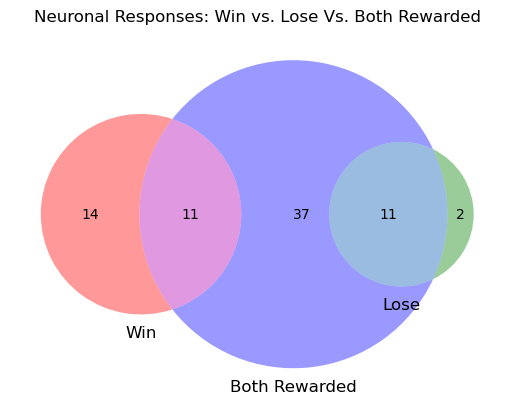

In [23]:
# (Abc, aBc, ABc, abC, AbC, aBC, ABC)

matplotlib_venn.venn3(subsets = (14, 2, 0, 37, 11, 11, 0), set_labels = ('Win', 'Lose', 'Both Rewarded'))

plt.title('Neuronal Responses: Win vs. Lose Vs. Both Rewarded')
# plt.show()
plt.savefig('Win_Lose_BothReward_Venn.png', bbox_inches='tight')